<a href="https://colab.research.google.com/github/runnithan03/Non-Parametric-Statistics/blob/main/Raul_Unnithan_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
import os

uploaded = files.upload()

uploaded_filename = list(uploaded.keys())[0]  # Get the uploaded file's original name
os.rename(uploaded_filename, 'vix_data.csv')

Saving VIX_historical_data.csv to VIX_historical_data.csv


In [5]:
%reload_ext rpy2.ipython

In [10]:
%%R
# --------------------------------------------------------
# Step 1: Data Acquisition and Preparation
# --------------------------------------------------------

# Load the data
vix_data <- read.csv('vix_data.csv')

# Select only the "Date" and "Close" columns
vix_data <- na.omit(vix_data[, c("Date", "Close")])

# Ensure "Close" is numeric
vix_data$Close <- as.numeric(vix_data$Close)

# Compute daily log returns using only the "Close" column
vix_returns <- diff(log(vix_data$Close)) * 100

# Check the resulting log returns
head(vix_returns)

[1] -3.319623 -3.387050 -4.037596  2.110393 -1.819970  1.725001


In [11]:
%%R

install.packages(c("quantmod", "boot", "bayesboot", "BNPmix", "cli"))
library(quantmod)
library(boot)
library(bayesboot)
library(BNPmix)
library(cli)

(as ‘lib’ is unspecified)



























	‘/tmp/RtmpuOvT9r/downloaded_packages’



In [12]:
%%R

# --------------------------------------------------------
# Step 2: Classical Bootstrap Analysis
# --------------------------------------------------------

# Function to compute the mean
# Define statistic function for mean
stat_function_mean <- function(data, indices) {
  sampled_data <- data[indices] # Resample data
  return(mean(sampled_data, na.rm = TRUE)) # Calculate mean
}

# Perform bootstrap
set.seed(123)
boot_mean <- boot(data = vix_returns, statistic = stat_function_mean, R = 1000)

# Confidence interval for mean
ci_mean <- boot.ci(boot_mean, type = "bca") # Use bias-corrected CI
print(ci_mean)

# Function to compute the variance
stat_function_variance <- function(data, indices) {
  sampled_data <- data[indices]
  return(var(sampled_data, na.rm = TRUE))
}

# Perform classical bootstrap for variance
set.seed(123)
boot_variance <- boot(data = vix_returns, statistic = stat_function_variance, R = 1000)

# Confidence Interval for variance
ci_variance <- boot.ci(boot_variance, type = "perc")
print(ci_variance)


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot_mean, type = "bca")

Intervals : 
Level       BCa          
95%   (-0.2810,  0.2829 )  
Calculations and Intervals on Original Scale
BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot_variance, type = "perc")

Intervals : 
Level     Percentile     
95%   (56.10, 70.93 )  
Calculations and Intervals on Original Scale


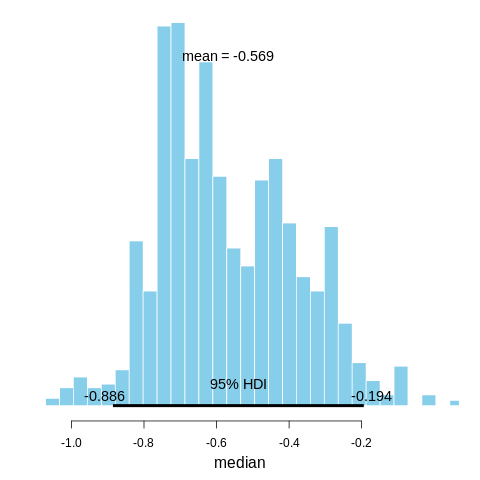

In [13]:
%%R

# --------------------------------------------------------
# Step 3: Bayesian Bootstrap Analysis
# --------------------------------------------------------

# Bayesian bootstrap for the median
set.seed(123)
bayes_boot_result <- bayesboot(as.numeric(vix_returns), statistic = median, R = 1000, na.rm = TRUE)

# Summary and plot
summary(bayes_boot_result)
plot(bayes_boot_result)

In [16]:
%%R
ls("package:BNPmix")

 [1] "BNPdens2coda"         "BNPdens2coda.BNPdens" "BNPmix_BIN"          
 [4] "BNPmix_psm"           "BNPmix_VI_LB"         "BNPpart"             
 [7] "clean_partition"      "dBNPdens"             "dBNPdens.BNPdens"    
[10] "DDPdensity"           "partition"            "partition.BNPdens"   
[13] "plot.BNPdens"         "print.BNPdens"        "PYcalibrate"         
[16] "PYdensity"            "PYregression"         "summary.BNPdens"     


Completed:	100/1000 - in 0.263598 sec
Completed:	200/1000 - in 1.0883 sec
Completed:	300/1000 - in 2.23669 sec
Completed:	400/1000 - in 3.18147 sec
Completed:	500/1000 - in 3.74035 sec
Completed:	600/1000 - in 4.20201 sec
Completed:	700/1000 - in 4.6346 sec
Completed:	800/1000 - in 5.07227 sec
Completed:	900/1000 - in 5.50732 sec
Completed:	1000/1000 - in 6.07342 sec

Estimation done in 6.08649 seconds
PYdensity function call:
 200 	burn-in iterations
 1000 	iterations 
 Global estimation time: 6.09 seconds
 Average number of groups:  7.99875 
 Min number of groups:  3 ; Max number of groups:  17 


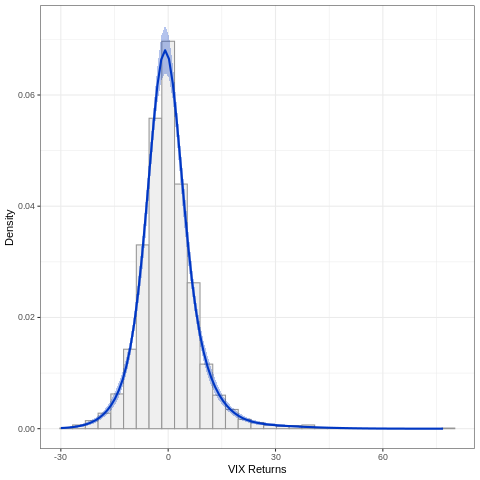

In [17]:
%%R

library(BNPmix)

# --------------------------------------------------------
# Step 4: Bayesian Nonparametric Analysis
# --------------------------------------------------------

# Bayesian Nonparametrics: Dirichlet Process Mixture Model using PYdensity
set.seed(123)

# Define MCMC parameters
mcmc <- list(niter = 1000, nburn = 200)  # 1000 iterations, 200 burn-in

# Define Prior Parameters
prior <- list(
  strength = 1,        # Prior strength (Dirichlet Process concentration)
  discount = 0,        # Discount parameter (0 means Dirichlet Process)
  hyper = FALSE        # No hierarchical prior (standard Dirichlet Process used)
)

# Define Output Grid
output <- list(
  grid = seq(min(vix_returns), max(vix_returns), length.out = 100),  # Evaluate posterior density
  out_param = TRUE  # Include full set of model parameters in output
)

# Fit the Dirichlet Process Mixture Model
dpmm_result <- PYdensity(
  y = as.numeric(vix_returns),  # Data: VIX returns
  mcmc = mcmc,
  prior = prior,
  output = output
)

# View the clustering summary
summary(dpmm_result)

# Plot the posterior density with 95% credible bands
plot(dpmm_result, band = TRUE, show_hist = TRUE, xlab = "VIX Returns", ylab = "Density")